In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from dax.help_functions.get_dax_data import get_data
from dax.help_functions.calculate_returns import calculate_returns

In [2]:
daxdata = get_data().iloc[8000:,]
daxdata = calculate_returns(daxdata,1)
daxdata = daxdata.loc[:, ['Close','CloseLag1', 'LogRetLag1']].set_index(daxdata.index.date)
daxdata

,Close,CloseLag1,LogRetLag1
2019-09-04,12025.040039,11910.860352,0.954053
2019-09-05,12126.780273,12025.040039,0.842511
2019-09-06,12191.730469,12126.780273,0.534164
2019-09-09,12226.099609,12191.730469,0.281509
2019-09-10,12268.709961,12226.099609,0.347914
...,...,...,...
2023-11-13,15345.000000,15234.389648,0.723434
2023-11-14,15614.429688,15345.000000,1.740578
2023-11-15,15748.169922,15614.429688,0.852870
2023-11-16,15786.610352,15748.169922,0.243797


## Visualizations

(array([19601., 19615., 19631., 19645., 19662., 19676.]),
 [Text(19601.0, 0, '2023-09-01'),
  Text(19615.0, 0, '2023-09-15'),
  Text(19631.0, 0, '2023-10-01'),
  Text(19645.0, 0, '2023-10-15'),
  Text(19662.0, 0, '2023-11-01'),
  Text(19676.0, 0, '2023-11-15')])

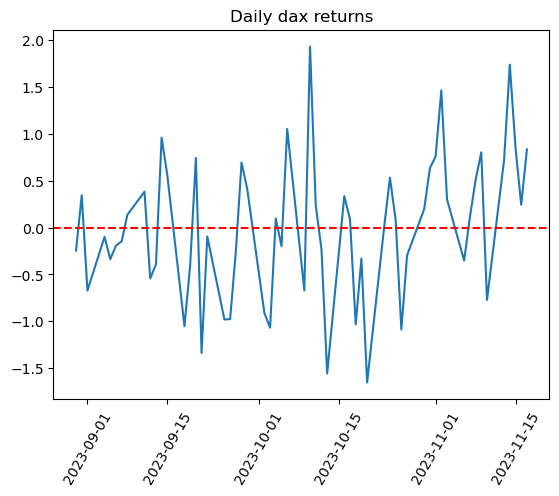

In [3]:
import matplotlib.pyplot as plt
daxdataplot = daxdata.iloc[1015:,]
plt.plot(daxdataplot['LogRetLag1'])
plt.axhline(0, color='red', linestyle='--', label='Level 0')
plt.title("Daily dax returns")
plt.xticks(rotation=60)

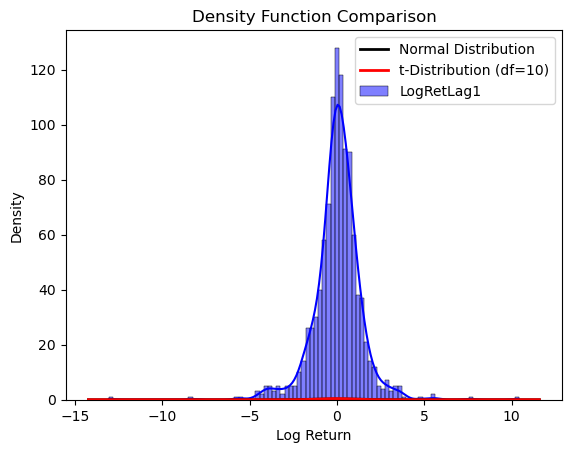

In [4]:
import seaborn as sns
from scipy.stats import norm, t

# Assuming df is your DataFrame
log_ret_lag1 = daxdata['LogRetLag1'].dropna()

# Plot the density function of LogRetLag1
sns.histplot(log_ret_lag1, kde=True, label='LogRetLag1', color='blue')

# Plot the density function of a normal distribution with the same mean and standard deviation
mu, std = 0, log_ret_lag1.std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

df_t = len(log_ret_lag1) - 1  # degrees of freedom
df_t2 = 10 # used in Arch documentation
p_t = t.pdf(x, df_t)
plt.plot(x, p_t, 'r', linewidth=2, label=f't-Distribution (df={df_t2})')

# Add labels and title
plt.title('Density Function Comparison')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()



Open Question: Underlying Normal Distribution seems pretty appropriate, t distribution does not --> why? (According to literature, t should be considered)
Different approach: GARCH(1,1) with leptokurtic error distribution

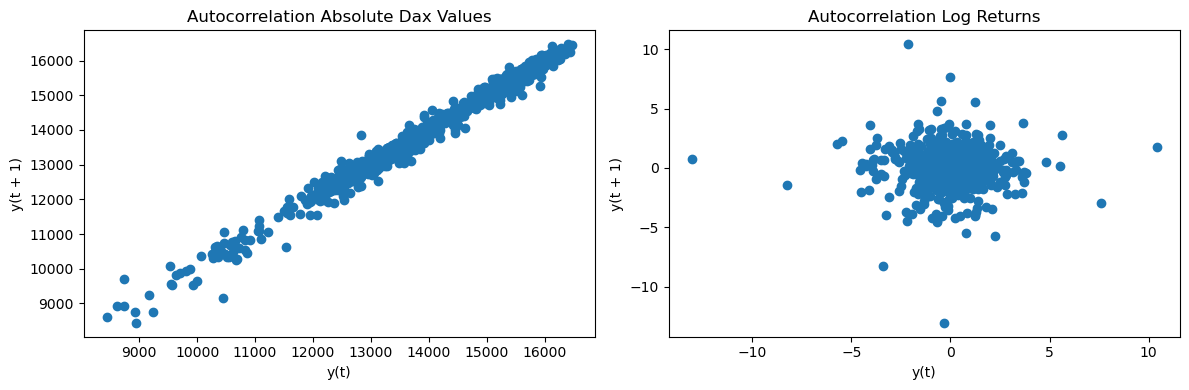

In [7]:
# Check Autocorrelation
from pandas.plotting import lag_plot
from matplotlib import pyplot

# Create a figure with two subplots in one row
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

lag_plot(daxdata['Close'], ax=axes[0])
axes[0].set_title('Autocorrelation Absolute Dax Values')

lag_plot(daxdata['LogRetLag1'], ax=axes[1])
axes[1].set_title('Autocorrelation Log Returns')

# Adjust layout
plt.tight_layout()

Autocorrelation clear to see, but by taking the returns, no autocorrelation anymore
Proven by literature: The findings confirm that the DAX returns are not serially correlated up to lag 20 (https://opus.uni-hohenheim.de/volltexte/2017/1307/pdf/Thesis_Final_Harald_Weiss.pdf


### Model Assumption

*Assumption of conditional heteroskedasticity:* 
* "volatility clustering" --> volatility not constant over time 
* means: periods of high volatility tend to be followed by periods of high volatility, ... 
* Therefore assume  $r_t|R_{t-1} ∼  N(0,σ_t^2)$

*Note*: 
* Specify mean equation too (combination with with AR(p) model senseful)
* Normal distribution assumed in GARCH --> t-distribution eventually better?

### GARCH-Model
GARCH(1,1):<br>
$R_t = ε_t$ <br>
$ε_t = \sqrt{h_t} u_t$ and $u_t ∼ N(0, 1)$ <br>
$h_t = α_0 + α_1R_{t-1}^2 + β_1h_{t−1}$

In [8]:
from arch import arch_model

# basic GARCH(1,1)
model_garch11 = arch_model(
    daxdata['LogRetLag1'], mean='constant', vol='GARCH', p=1, q=1).fit()

# compare to GARCH(1,2) via AIC, BIC
model_garch12 = arch_model(
    daxdata['LogRetLag1'], mean='constant', vol='GARCH', p=1, q=2).fit()

# compare to GARCH(1,1) with zero constant
model_garch_zero = arch_model(
    daxdata['LogRetLag1'], mean='zero', vol='GARCH', p=1, q=1).fit()

# compare to GARCH(1,1) with t distribution
model_garch_t = arch_model(
    daxdata['LogRetLag1'], mean='constant', vol='GARCH', p=1, q=1).fit()

# compare to GARCH(1,1) with zero constant and t distribution
model_garch_zero_t = arch_model(
    daxdata['LogRetLag1'], mean='zero', vol='GARCH', dist="StudentsT", p=1, q=1).fit()


# extract AIC and BIC for each model
results = {
    "Model": ["GARCH(1,1)", "GARCH(1,2)", "GARCH(1,1) with mean zero", "GARCH(1,1) with t dist", "GARCH(1,1) with mean zero and t dist"],
    "AIC": [model_garch11.aic, model_garch12.aic, model_garch_zero.aic, model_garch_t.aic, model_garch_zero_t.aic],
    "BIC": [model_garch11.bic, model_garch12.bic, model_garch_zero.bic, model_garch_t.bic, model_garch_zero_t.bic]
}

# create a DataFrame
comparison_df = pd.DataFrame(results)
comparison_df

Iteration:      1,   Func. Count:      6,   Neg. LLF: 22480.694785404947
Iteration:      2,   Func. Count:     15,   Neg. LLF: 108717615182.00758
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2131.1183257254156
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2128.9476614551118
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1686.572749576067
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1684.2811710184042
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1684.2670180317336
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1684.2666987834464
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1684.2666590383676
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1684.2666388902028
Iteration:     11,   Func. Count:     67,   Neg. LLF: 1684.266638329308
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1684.266638329308
            Iterations: 11
            Function evaluations: 67
            Gradient evalua

,Model,AIC,BIC
0,"GARCH(1,1)",3376.533277,3396.446132
1,"GARCH(1,2)",3377.875754,3402.766822
2,"GARCH(1,1) with mean zero",3378.924972,3393.859613
3,"GARCH(1,1) with t dist",3376.533277,3396.446132
4,"GARCH(1,1) with mean zero and t dist",3275.268307,3295.181162


### Interpretation
* p-values very small --> Significance of all parameters, GARCH(1,1) and GARCH(1,2) models propriate to estimate volatiliy
* sum of the estimated ARCH and GARCH parameters is close to one (0.995) in each model, which indicates that DAX volatility is highly
persistent (GARCH(1,1) model is stationary for $α_1$ + $β_1$ < 1)
* should continue with GARCH(1,1) with t distribution, since AIC and BIC values are the smallest (See Arch docs: Financial returns are often heavy tailed, and a Student’s T distribution is a simple method to capture this feature)
* nevertheless: easier to start with normal distributed errors --> first step

In [9]:
# forecasting quantiles of model_garch_zero 

import pandas as pd
from scipy.stats import norm

forecast = model_garch_zero.forecast(horizon=5, reindex=False)
forecast_variances = forecast.variance

# Define the quantiles
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

# Create DataFrame storing quantile forecasts in submission form
quantile_forecasts = pd.DataFrame({
    "target": "DAX",
    "horizon": [str(i) + " day" for i in (1, 2, 5, 6, 7)],
    "variance": forecast_variances.iloc[0].values})

# Calculate quantiles for each variance
for q in quantiles:
    quantile_forecasts[f'q{q}'] = quantile_forecasts['variance'].apply(
        lambda x: norm.ppf(q, loc=0, scale=np.sqrt(x)))
    
last_date = daxdata.index[-1]
first_index_date = last_date + pd.Timedelta(days=1)
quantile_forecasts.index = pd.date_range(
        start=first_index_date, periods=5, freq='B')

date_st = (datetime.today().strftime('%Y-%m-%d'))
quantile_forecasts.insert(0, 'forecast_date', date_st)
quantile_forecasts = quantile_forecasts.drop(columns={'variance'})


In [12]:
# forecast of quantiles with model_garch_zero_t 

# get required paramters
coeff = model_garch_zero_t.params

# calculate variance for last timestamp 
h_0 = model_garch_zero_t.conditional_volatility[-1]                                                             #correct?

# more approximate to say residuals instead of logreturnforecast
def simulate_GARCH(h, coeff, daxdata, h_0):

    # initialize parameters
    last_return = daxdata.iloc[-1].loc['LogRetLag1']
    np.random.seed(100)
    white_noise = np.random.standard_t(df=5, size=h)
    residuals = np.zeros(h)
    residuals[0] = float(last_return)
    variance = np.zeros(h)
    variance[0] = h_0

    for t in range(1, h):
        # Simulate the variance (sigma squared)
        # ++ coeff[1] * residuals[t-1]**2
        variance[t] = coeff[0] + coeff[2] * \
            variance[t-1] + coeff[1] * residuals[t-1]**2
        # Simulate the residuals (= returns?)
        residuals[t] = np.sqrt(variance[t]) * white_noise[t]

    dax_forecasts = pd.DataFrame({
        "horizon": [str(i) + " day" for i in (0, 1, 2, 5, 6, 7)], 
        "variance": variance, 
        "residuals":residuals})
    
    first_index_date = daxdata.index[-1] 
    dax_forecasts.index = pd.date_range(
        start=first_index_date, periods=h, freq='B')
    
    return dax_forecasts

forecasts = simulate_GARCH(6, coeff, daxdata, h_0)
forecasts

,horizon,variance,residuals
2023-11-17,0 day,1.011371,0.836129
2023-11-20,1 day,0.902719,0.485712
2023-11-21,2 day,0.812127,0.324638
2023-11-22,5 day,0.736592,-0.645420
2023-11-23,6 day,0.673613,-0.350706
2023-11-24,7 day,0.621101,-0.860359


### Calculate Quantile Forecasts
Formula:
$ \hat{Q}_{q,t+h} = \hat{R}_{t+h}- t_{5, 1-q}*\sqrt{\hat{h}_{t+h}} $

In [112]:
from scipy.stats import t

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

def calculate_Q_hat(row, quantile):
    return row['returnForecast'] - t.ppf((1-quantile), 5) * np.sqrt(row['variance'])

for q in quantiles:
    forecasts[f'q{q}'] = forecasts.apply(calculate_Q_hat, quantile=q, axis=1)
forecasts

,horizon,variance,returnForecast,q0.025,q0.25,q0.5,q0.75,q0.975
2023-11-15,0 day,1.085392,0.852870,-1.825218,0.095792,0.852870,1.609948,3.530957
2023-11-16,1 day,1.071531,0.529182,-2.131750,-0.223046,0.529182,1.281411,3.190114
2023-11-17,2 day,0.993793,0.359117,-2.203475,-0.365311,0.359117,1.083545,2.921709
2023-11-20,5 day,0.906700,-0.716078,-3.163807,-1.408035,-0.716078,-0.024121,1.731650
2023-11-21,6 day,0.890959,-0.403336,-2.829724,-1.089260,-0.403336,0.282588,2.023052
2023-11-22,7 day,0.826048,-0.992205,-3.328535,-1.652670,-0.992205,-0.331740,1.344125


### Specification of the Conditional Mean
Specifying the variance equation for the GARCH models requires the identification 
of an appropriate model for the conditional mean. <br>

Diebold (1988) demonstrates that Bartlett’s confidence bands are overly conservative in the 
presence of ARCH effects --> Use of Barlett’s original formula can lead to 
a misspecification of the ARMA process for the conditional mean, since the original formula 
underestimates the variances of the sample autocorrelations.<br>
Thus, the corrected 95% confidence interval B(τ) for the sample autocorrelation 
$\hat{p}(τ)$ is calculated based on Diebold’s formula: <br>
<br>
$B(τ) = 0 ± 1.96 \sqrt{S(τ)}$ <br>
$S(τ) = 1/T* (1 + \frac{\hat{y}(τ)}{\hat{σ^4}})$

* S(τ): variance of sample autocorrelations
* $\hat{y}(τ)$, $\hat{p}(τ)$: estimated autocovariance of the squared DAX returns
* $\hat{σ^4}$: squared sample variance of the DAX returns

Dax returns not correlated anymore (also proven by paper, see link), means <br>
$E[r_t |I_{t−1}] = µ$

In [18]:
# Try out ARX model 
from arch.univariate import ARX
ar = ARX(daxdata['LogRetLag1'], lags=[1])
print(ar.fit().summary())
# p-Values not significant --> Stick to constant mean

                     AR - Constant Variance Model Results                     
Dep. Variable:             LogRetLag1   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:          Constant Variance   Log-Likelihood:               -1872.50
Distribution:                  Normal   AIC:                           3751.00
Method:            Maximum Likelihood   BIC:                           3765.93
                                        No. Observations:                 1070
Date:                Thu, Nov 16 2023   Df Residuals:                     1068
Time:                        08:17:32   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const             0.0258  4.275e-02      0.604

In [61]:
# Generate forecasts
forecast_result = model_garch11.forecast(horizon=10)

# Extract quantiles for the desired levels
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

# Extract quantile forecasts for each horizon
quantile_forecasts = forecast_result.variance.quantile(q=quantiles, axis=0)

# Print or use the quantile forecasts
print(quantile_forecasts)
print(forecast_result.mean)

forecast_values = forecast_result.mean.iloc[-1].values
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]


           h.01      h.02      h.03      h.04     h.05      h.06      h.07  \
0.025  1.086811  1.124115  1.159757  1.193812  1.22635  1.257439  1.287143   
0.250  1.086811  1.124115  1.159757  1.193812  1.22635  1.257439  1.287143   
0.500  1.086811  1.124115  1.159757  1.193812  1.22635  1.257439  1.287143   
0.750  1.086811  1.124115  1.159757  1.193812  1.22635  1.257439  1.287143   
0.975  1.086811  1.124115  1.159757  1.193812  1.22635  1.257439  1.287143   

           h.08      h.09     h.10  
0.025  1.315524  1.342641  1.36855  
0.250  1.315524  1.342641  1.36855  
0.500  1.315524  1.342641  1.36855  
0.750  1.315524  1.342641  1.36855  
0.975  1.315524  1.342641  1.36855  
                h.01      h.02      h.03      h.04      h.05      h.06  \
2023-11-15  0.064465  0.064465  0.064465  0.064465  0.064465  0.064465   

                h.07      h.08      h.09      h.10  
2023-11-15  0.064465  0.064465  0.064465  0.064465  


# Next steps
Mean model specifications: autoregressive mean: model the mean as an autoregressive (AR) process 
Conclusion: does not make sense --> No AR(p) model for mean

In [81]:
from statsmodels.tsa.ar_model import AutoReg  
model = AutoReg(daxdata['LogRetLag1'], lags=1).fit()
model.summary()

c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             LogRetLag1   No. Observations:                 1071
Model:                     AutoReg(1)   Log Likelihood               -1872.465
Method:               Conditional MLE   S.D. of innovations              1.392
Date:                Wed, 15 Nov 2023   AIC                           3750.929
Time:                        14:52:25   BIC                           3765.855
Sample:                             1   HQIC                          3756.584
                                 1071                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0258      0.043      0.605      0.545      -0.058       0.109
LogRetLag1.L1    -0.0245      0.031     -0.803      0.422      -0.084       0.035
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -40.7744           +0.0000j           40.7744            0.5000
-----------------------------------------------------------------------------
"""